Hi I'm 王渙鈞, M114020052

Google Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Versions of used packages

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.15 (default, Oct 12 2022, 19:14:55) 
torch 1.12.1+cu113
torchvision 0.13.1+cu113


Unzip Data

In [ ]:
!unzip -qq ./drive/My\ Drive/deep_fashion.zip

In [ ]:
data_folder = 'deep_fashion'

Custom dataset

In [ ]:
import csv
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch

class FashionData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode 
        self.data_list = []
        self.category_labels = []
        self.attribute_labels = []
        self.transform = transform
        
        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(f"{row['file_path']}")
                if mode != 'test':
                    self.category_labels.append(row['category_label'])
                    self.attribute_labels.append(row['attribute_label'])

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        category_label = torch.tensor(int(self.category_labels[index]))
        attribute_label = torch.tensor([int(i) for i in self.attribute_labels[index].split()]) #!!!
        attribute_label = torch.zeros(15).scatter_(0, attribute_label, 1)
        #print(attribute_label)
        return data, category_label, attribute_label 
 
    def __len__(self):
        return len(self.data_list)

Data augmentation

In [ ]:
from torchvision import transforms
# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
transforms_train = transforms.Compose([
  transforms.Resize((256,256)),
  transforms.RandomCrop((224,224)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.RandomRotation(degrees=(-90,90)),
  transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])
########################################################################
#                           End of your code                           #
########################################################################

# For VAL, TEST
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_test = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])
########################################################################
#                           End of your code                           #
########################################################################

Instantiate dataset

In [ ]:
dataset_train = FashionData('train.csv', mode='train', transform=transforms_train)
dataset_val = FashionData('val.csv', mode='val', transform=transforms_test)
dataset_test = FashionData('test.csv', mode='test', transform=transforms_test)

In [ ]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(1)[0].size())
print("There are", dataset_train.__len__(), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 39092 images in dataset_train.


DataLoader

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
num_workers = 2
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Define a Convolutional Neural Network

In [ ]:
import torchvision.models as models
import torch.nn as nn 

MODELS = {
	"resnet50": models.resnet50(pretrained=True),
}


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
class Double_Head_Linear(torch.nn.Module):
    def __init__(self, Linear1, Linear2):
        super(Double_Head_Linear, self).__init__()
        self.linear1 = Linear1
        self.linear2 = Linear2

    def forward(self, input):
        return self.linear1(input), self.linear2(input)

class CNN_Model(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.cnn_model = MODELS['resnet50']
        in_features = self.cnn_model.fc.in_features
        self.cnn_model.fc = Double_Head_Linear(nn.Linear(in_features, 10), nn.Linear(in_features, 15))

    def forward(self, x): 
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)

        out1, out2 = self.cnn_model(x)

        return out1, out2

In [ ]:
device = torch.device('cuda')
# or
#device = torch.device('cpu')

In [ ]:
model = CNN_Model() 
model = model.to(device)

Define loss and optimizer

In [ ]:
import torch.nn as nn
import torch.optim as optim

# TODO: Define loss and optmizer functions                                     
criterion1, criterion2 = nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

criterion1 = criterion1.to(device)
criterion2 = criterion2.to(device)

Train the model

In [ ]:
from sklearn.metrics import f1_score
acc_threshold = 0.5
alpha, beta = 1, 8

In [ ]:
def train(input_data, model, criterion1, criterion2, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    pred = []
    attr_labels = []
    loss_list = []
    total_count = 0
    acc_count = 0
    for images, category_labels, attribute_labels in input_data:
        images = images.to(device)
        category_labels = category_labels.to(device)
        attribute_labels = attribute_labels.to(device)
        
        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        optimizer.zero_grad()
        out1, out2 = model.forward(images)
        loss1 = criterion1(out1, category_labels)
        loss2 = criterion2(out2, attribute_labels)
        loss = loss1 * alpha + loss2 * beta
        loss.backward()
        optimizer.step()
        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################
        _, predicted1 = torch.max(out1.data, dim=1)
        predicted2 = (out2.data > acc_threshold).int()
        pred += predicted2.tolist()      
        attr_labels += attribute_labels.int().tolist()
        total_count += category_labels.size(0)
        acc_count += (predicted1 == category_labels).sum().item()
        loss_list.append(loss.item())
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    f1 = f1_score(pred, attr_labels, average='samples')
    loss = sum(loss_list) / len(loss_list)
    return acc, f1, loss
  

Validate function

In [ ]:
def val(input_data, model, criterion1, criterion2):
    model.eval()
    
    loss_list = []
    pred = []
    attr_labels = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for images, category_labels, attribute_labels in input_data:
            images = images.to(device)
            category_labels = category_labels.to(device)
            attribute_labels = attribute_labels.to(device)

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            out1, out2 = model.forward(images)
            loss1 = criterion1(out1, category_labels)
            loss2 = criterion2(out2, attribute_labels)
            loss = loss1*alpha + loss2*beta
            
            _, predicted1 = torch.max(out1.data, dim=1)
            predicted2 = (out2.data > acc_threshold).int()
            pred += predicted2.tolist()
            attr_labels += attribute_labels.int().tolist()
            total_count += category_labels.size(0)
            acc_count += (predicted1 == category_labels).sum().item()
            loss_list.append(loss.item())
            ####################################################################
            #                         End of your code                         #
            ####################################################################

    acc = acc_count / total_count
    f1 = f1_score(pred, attr_labels, average='samples')
    loss = sum(loss_list) / len(loss_list)
    return acc, f1, loss

Training in a loop

In [ ]:
os.makedirs('./drive/MyDrive/Colab Notebooks/assign4_ckpts', exist_ok=True)

In [ ]:
from sklearn.metrics import f1_score

max_epochs = 20

log_interval = 2 

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
train_f1_list = []
val_f1_list = []
for epoch in range(1, max_epochs + 1):
    
    train_acc, train_f1, train_loss = train(train_loader, model, criterion1, criterion2, optimizer)
    val_acc, val_f1, val_loss = val(val_loader, model, criterion1, criterion2)
    scheduler.step()

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    train_f1_list.append(train_f1)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    val_f1_list.append(val_f1)
    if epoch % log_interval == 0:
        print('=' * 30, 'Epoch', epoch, '=' * 30)
        print('Train acc(category): {:.6f} Train f1(attribute): {:.6f} Train Loss: {:.6f}'.format(train_acc, train_f1, train_loss))
        print('  Val acc(category): {:.6f}   Val f1(attribute): {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_f1, val_loss))
        if(val_acc>0.55 and val_f1>0.35):
            torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/assign4_ckpts/resnet50{:03}_vacc_{:.02}_vf1_{:.02}_vloss_{:.02}.pt'.format(epoch,val_acc, val_f1, val_loss))
torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/assign4_ckpts/resnet50{:03}_vacc_{:.02}_vf1_{:.02}_vloss_{:.02}.pt'.format(epoch,val_acc, val_f1, val_loss))

NameError: ignored

Visualize accuracy and loss

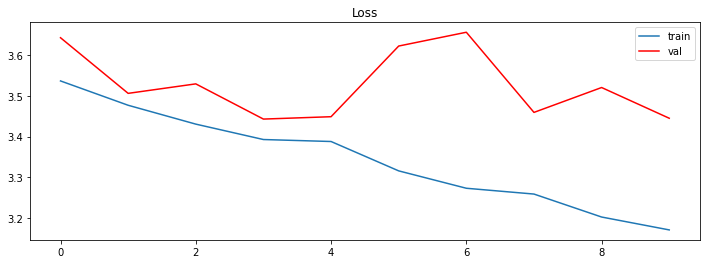

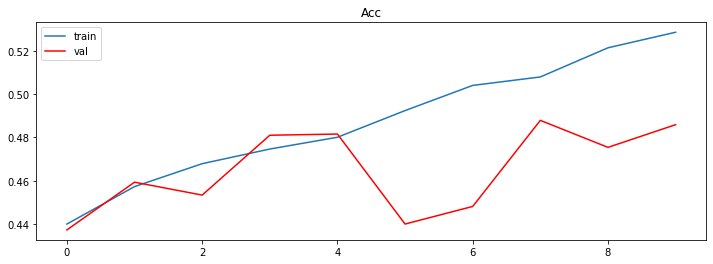

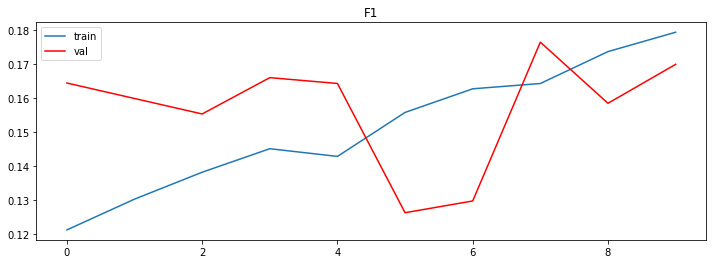

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_f1_list)), train_f1_list)
plt.plot(range(len(val_f1_list)), val_f1_list, c='r')
plt.legend(['train', 'val'])
plt.title('F1')
plt.show()

Predict Result

In [ ]:
def predict_C(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in input_data:
            images = data.to(device)
            outputs = model(images)[0]
            _, predicted = torch.max(torch.softmax(outputs.data, 1), 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [ ]:
idx = 0
output_csv = predict_C(test_loader, model)
with open('result_C.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'category_label'])
    writer.writeheader()
    for result in output_csv:
        file_path = dataset_test.data_list[idx]
        writer.writerow({'file_path':file_path, 'category_label':result})
        idx += 1

In [ ]:
def predict_A(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            outputs = model(images)[1]
            predicted = (torch.sigmoid(outputs.data) > 0.25).int()
            index = []
            for img in range(len(predicted)):
                index = []
                for i in range(len(predicted[img])):
                    if(predicted[img][i]==1):
                        index.append(str(i))
                output_list.append(' '.join(index)) 
    return output_list

In [ ]:
idx = 0
output_csv = predict_A(test_loader, model)
with open('result_A.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'attribute_label'])
    writer.writeheader()
    for result in output_csv:
        file_path = dataset_test.data_list[idx]
        writer.writerow({'file_path':file_path, 'attribute_label':result})
        idx += 1